Step 1 — Setup & GPU check

What this does: imports essentials, checks that Colab sees a GPU, and sets seeds for reproducibility.

In [ ]:
# Step 1: Setup & GPU check
import os, sys, random, json, zipfile, glob, shutil, textwrap
import numpy as np
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
if not tf.config.list_physical_devices('GPU'):
    print("⚠️ No GPU detected. In Colab: Runtime → Change runtime type → Hardware accelerator: GPU")

# Reproducibility
SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Step 2 — Mount Google Drive & create project folders

What this does: mounts Drive and creates folders where we’ll save checkpoints, logs, and exported models so your progress survives disconnects.

In [ ]:
# Step 2: Mount Google Drive and set base directories
from google.colab import drive
import os

drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/PlantDisease_EfficientNetB0"
ckpt_dir = os.path.join(base_dir, "checkpoints")
log_dir = os.path.join(base_dir, "logs")
export_dir = os.path.join(base_dir, "export")

os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(export_dir, exist_ok=True)

print("Base Dir:", base_dir)
print("Checkpoints:", ckpt_dir)
print("Logs:", log_dir)
print("Export:", export_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base Dir: /content/drive/MyDrive/PlantDisease_EfficientNetB0
Checkpoints: /content/drive/MyDrive/PlantDisease_EfficientNetB0/checkpoints
Logs: /content/drive/MyDrive/PlantDisease_EfficientNetB0/logs
Export: /content/drive/MyDrive/PlantDisease_EfficientNetB0/export


Step 3 — Install helper libraries

What this does: installs small, safe helper libs:

split-folders to create train/val/test directories,

scikit-learn and seaborn for metrics/plots.

In [ ]:
# Step 3: Install helper libraries
!pip install -U split-folders scikit-learn seaborn


Step 4 — Point to your dataset ZIP & extract

What this does: points to your PlantVillage ZIP in Drive and extracts it.
👉 Update ZIP_PATH to match where you put the ZIP (e.g., /content/drive/MyDrive/plantVillage.zip).

In [ ]:
# Step 4: Extract dataset
import zipfile

zip_path = "/content/drive/MyDrive/PlantVillage.zip"  # exact filename
extract_path = os.path.join(base_dir, "dataset")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset


Step 5 — Auto-detect the dataset root folder

What this does: finds the folder that directly contains the class subfolders (e.g., Tomato___Late_blight, …). This is necessary because different zips often nest folders differently.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive


 Classroom	    FastChat   PlantDisease_EfficientNetB0
'Colab Notebooks'   fyp        PlantVillage.zip


In [ ]:
!ls /content/drive/MyDrive/PlantDisease_EfficientNetB0


checkpoints  dataset  export  logs


In [ ]:
!ls /content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset


plantvillage  PlantVillage


In [ ]:
!ls /content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage

PlantVillage


In [ ]:
!ls /content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage

Pepper__bell___Bacterial_spot  Tomato_Late_blight
Pepper__bell___healthy	       Tomato_Leaf_Mold
Potato___Early_blight	       Tomato_Septoria_leaf_spot
Potato___healthy	       Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Late_blight	       Tomato__Target_Spot
Tomato_Bacterial_spot	       Tomato__Tomato_mosaic_virus
Tomato_Early_blight	       Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_healthy


In [ ]:
import os

# Correct dataset path
DATASET_ROOT = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage"

# Print path and first 10 class names
print("DATASET_ROOT:", DATASET_ROOT)
print("Classes:", os.listdir(DATASET_ROOT)[:10])


DATASET_ROOT: /content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']


In [ ]:
# Manually set the dataset root (your confirmed correct path)
DATASET_ROOT = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage"

print("DATASET_ROOT:", DATASET_ROOT)
print("Classes:", os.listdir(DATASET_ROOT)[:10])


DATASET_ROOT: /content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']


Step 6: Train/Validation Split + Data Preprocessing.
We’ll use ImageDataGenerator to:

Normalize images (scale pixel values between 0 and 1).

Apply data augmentation (rotation, zoom, flips, etc. for generalization).

Split the dataset into training and validation sets.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size (EfficientNetB0 default input is 224x224)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,            # normalize pixel values
    rotation_range=20,         # random rotation
    width_shift_range=0.2,     # horizontal shift
    height_shift_range=0.2,    # vertical shift
    shear_range=0.2,           # shear transform
    zoom_range=0.2,            # zoom
    horizontal_flip=True,      # flip images horizontally
    validation_split=0.2       # 20% of data for validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_ROOT,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    DATASET_ROOT,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("Classes detected:", train_generator.class_indices)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Classes detected: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


Step 7: Build the EfficientNetB0 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load EfficientNetB0 base model
base_model = EfficientNetB0(
    include_top=False,    # no classification head
    weights='imagenet',   # use pretrained ImageNet weights
    input_shape=(224, 224, 3)
)

# Freeze base model layers for transfer learning
base_model.trainable = False

# Build custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Step 8: Callbacks & Training Setup
Stop training early if validation loss stops improving.

Reduce learning rate if progress stalls.

Save the best model in your Google Drive (checkpoints/best_model.h5).


In [ ]:
# Step 8: Define checkpoint directory
checkpoint_dir = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/checkpoints"

# Create directory if it doesn’t exist
os.makedirs(checkpoint_dir, exist_ok=True)

print("Checkpoint directory set to:", checkpoint_dir)


Checkpoint directory set to: /content/drive/MyDrive/PlantDisease_EfficientNetB0/checkpoints


In [ ]:
import os

# Paths to both versions
folder1 = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage"
folder2 = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/PlantVillage/"

def count_images_in_folder(folder_path):
    count_dict = {}
    total = 0
    if not os.path.exists(folder_path):
        print(f" Folder not found: {folder_path}")
        return None
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            count_dict[class_name] = num_images
            total += num_images
    return count_dict, total

# Count for both
counts1, total1 = count_images_in_folder(folder1)
counts2, total2 = count_images_in_folder(folder2)

print("=== Folder 1: PlantVillage ===")
print(f"Total images: {total1}")
print(counts1)

print("\n=== Folder 2: plantvillage ===")
print(f"Total images: {total2}")
print(counts2)


=== Folder 1: PlantVillage ===
Total images: 20639
{'Pepper__bell___Bacterial_spot': 997, 'Pepper__bell___healthy': 1478, 'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000, 'Potato___healthy': 152, 'Tomato_Bacterial_spot': 2127, 'Tomato_Early_blight': 1000, 'Tomato_Late_blight': 1909, 'Tomato_Leaf_Mold': 952, 'Tomato_Septoria_leaf_spot': 1771, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676, 'Tomato__Target_Spot': 1404, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209, 'Tomato__Tomato_mosaic_virus': 373, 'Tomato_healthy': 1591}

=== Folder 2: plantvillage ===
Total images: 20639
{'Pepper__bell___Bacterial_spot': 997, 'Pepper__bell___healthy': 1478, 'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000, 'Potato___healthy': 152, 'Tomato_Bacterial_spot': 2127, 'Tomato_Early_blight': 1000, 'Tomato_Late_blight': 1909, 'Tomato_Leaf_Mold': 952, 'Tomato_Septoria_leaf_spot': 1771, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676, 'Tomato__Target_Spot': 1404, 'Tomato__Tomato_

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ------------ Paths ------------
DATASET_ROOT = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage"
CKPT_DIR = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
checkpoint_path = os.path.join(CKPT_DIR, "best_model.keras")  # new Keras format

# ------------ Generators (no copy, split on the fly) ------------
IMG_SIZE = (224, 224)
BATCH = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2   # 80/20 split without duplicating files
)

train_generator = datagen.flow_from_directory(
    DATASET_ROOT,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=True,
    subset="training",
    seed=42
)

val_generator = datagen.flow_from_directory(
    DATASET_ROOT,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False,
    subset="validation",
    seed=42
)

num_classes = train_generator.num_classes
print("Classes:", train_generator.class_indices)
print("Train samples:", train_generator.n, " Val samples:", val_generator.n)

# ------------ Model ------------
base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation="softmax")(x)
model = Model(base.input, out)

# ------------ Callbacks (saves to Drive every epoch if improved) ------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# ------------ Training: Phase 1 (freeze base) ------------
base.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy", metrics=["accuracy"])
print("Phase 1: head training...")
model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=callbacks)

# ------------ Training: Phase 2 (fine-tune last 50 layers) ------------
for layer in base.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="categorical_crossentropy", metrics=["accuracy"])
print("Phase 2: fine-tuning...")
model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=callbacks)

# ------------ Save final model to Drive ------------
final_model_path = os.path.join(CKPT_DIR, "final_model.keras")
model.save(final_model_path)
print("Saved:", final_model_path)


KeyboardInterrupt: 

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# =============================
# 🔹 Paths
# =============================
train_dir = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir   = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

# Checkpoint path (saves after each epoch if val_accuracy improves)
checkpoint_dir = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "best_model.h5")

# =============================
# 🔹 Data Generators
# =============================
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen   = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

num_classes = train_generator.num_classes

# =============================
# 🔹 Model Architecture
# =============================
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

# =============================
# 🔹 Callbacks (save progress!)
# =============================
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# =============================
# 🔹 Phase 1: Train top layers
# =============================
base_model.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy", metrics=["accuracy"])

history1 = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=callbacks)

# =============================
# 🔹 Phase 2: Fine-tuning last 50 layers
# =============================
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="categorical_crossentropy", metrics=["accuracy"])

history2 = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=callbacks)

# =============================
# 🔹 Save Final Model
# =============================
final_model_path = os.path.join(checkpoint_dir, "final_model.keras")
model.save(final_model_path)
print(f"Training complete! Final model saved at {final_model_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PlantVillage/train'

In [ ]:
!ls /content/drive/MyDrive


 Classroom	    FastChat   PlantDisease_EfficientNetB0
'Colab Notebooks'   fyp        PlantVillage.zip


In [ ]:
!ls /content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage

Pepper__bell___Bacterial_spot  Tomato_Late_blight
Pepper__bell___healthy	       Tomato_Leaf_Mold
Potato___Early_blight	       Tomato_Septoria_leaf_spot
Potato___healthy	       Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Late_blight	       Tomato__Target_Spot
Tomato_Bacterial_spot	       Tomato__Tomato_mosaic_virus
Tomato_Early_blight	       Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_healthy


In [ ]:
# ====== 1. Mount your Drive ======
from google.colab import drive
drive.mount('/content/drive')

# ====== 2. Install gdown (for shared Google Drive links) ======
!pip install -q gdown

# ====== 3. Copy shared PlantVillage folder into your Drive ======
# (replace with your shared link if needed)
shared_folder_url = "https://drive.google.com/drive/folders/1inr8q6293RxZ7ljVMKKm-IqwN9J4-vXb?usp=sharing"
target_path = "/content/drive/MyDrive/PlantDisease_EfficientNetB0"

!gdown --folder $shared_folder_url -O $target_path

# ====== 4. Check dataset structure ======
import os

for split in ["train", "val", "test"]:
    split_path = os.path.join(target_path, split)
    if os.path.exists(split_path):
        print(f"=== {split} set ===")
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            if os.path.isdir(cls_path):
                print(f"{cls}: {len(os.listdir(cls_path))} images")
    else:
        print(f"{split} folder not found in dataset.")


Mounted at /content/drive
Retrieving folder contents
Retrieving folder 1rV6kuaY1MIpnmpVHKGeQ-JYk6GbaNo3j checkpoints
Retrieving folder 1LOAQwvYGcz2b9pe41767q03q2kV56dkD dataset
Retrieving folder 1_jaPcc_q_IWu91b8xYEWROn-_c66SyAN plantvillage
Retrieving folder 1sChy0hLZkg1U8HaEZwv5r5SXqZjbK4ML PlantVillage
Retrieving folder 1Gc92oIkUGcVLwHcU8aptHKoQ2eC6u83B Pepper__bell___Bacterial_spot
Processing file 1n_btrj9wnBIrBcaGXPOwEzKPGHID_g-B 0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG
Processing file 1ontYp9jfDh5HaSuWgKpPEJxUdUisYlnY 0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG
Processing file 1jiy6tMMb2YYqnhxoDAOouTG1EeSEDLX2 0a9cfb27-280e-475a-bbb4-8eeaeff38b8c___NREC_B.Spot 9177.JPG
Processing file 1bgUKhhu_biYKjt3_kDd3f_OdXSnqBoAZ 0abffc81-6be8-4b17-a83c-4d2830e30382___JR_B.Spot 9076.JPG
Processing file 1P-0YJ0a3kSbwz5a6-Q9yVMZ87QwVURN- 0b27c03f-b3bc-4d96-9b76-6fbd779404b9___NREC_B.Spot 1799.JPG
Processing file 1SVVxE9UuIwNyHrPp-vkH_PUQYU1DDyvz 0b47ce18-7cfe

In [ ]:
!pip install gdown

# Example: download a whole shared folder (zip it first in old Drive)
!gdown --folder 'https://drive.google.com/drive/folders/1inr8q6293RxZ7ljVMKKm-IqwN9J4-vXb?usp=sharing' -O /content/PlantDisease_EfficientNetB0


Retrieving folder contents
Retrieving folder 1rV6kuaY1MIpnmpVHKGeQ-JYk6GbaNo3j checkpoints
Retrieving folder 1LOAQwvYGcz2b9pe41767q03q2kV56dkD dataset
Retrieving folder 1_jaPcc_q_IWu91b8xYEWROn-_c66SyAN plantvillage
Retrieving folder 1sChy0hLZkg1U8HaEZwv5r5SXqZjbK4ML PlantVillage
Retrieving folder 1Gc92oIkUGcVLwHcU8aptHKoQ2eC6u83B Pepper__bell___Bacterial_spot
Processing file 1n_btrj9wnBIrBcaGXPOwEzKPGHID_g-B 0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG
Processing file 1ontYp9jfDh5HaSuWgKpPEJxUdUisYlnY 0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG
Processing file 1jiy6tMMb2YYqnhxoDAOouTG1EeSEDLX2 0a9cfb27-280e-475a-bbb4-8eeaeff38b8c___NREC_B.Spot 9177.JPG
Processing file 1bgUKhhu_biYKjt3_kDd3f_OdXSnqBoAZ 0abffc81-6be8-4b17-a83c-4d2830e30382___JR_B.Spot 9076.JPG
Processing file 1P-0YJ0a3kSbwz5a6-Q9yVMZ87QwVURN- 0b27c03f-b3bc-4d96-9b76-6fbd779404b9___NREC_B.Spot 1799.JPG
Processing file 1SVVxE9UuIwNyHrPp-vkH_PUQYU1DDyvz 0b47ce18-7cfe-45e8-b21e-b83cb6282455___

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

data_dir = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage"


In [ ]:
from tensorflow import keras

model = keras.models.load_model(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model.h5"
)


In [ ]:
import tensorflow as tf

img_size = (224, 224)   # same size you trained on
batch_size = 32

train_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir   = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",   # for softmax
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(image, label):
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess)
val_ds   = val_ds.map(preprocess)


In [ ]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

# Compile again so training works
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",   # since you have 15 classes
    metrics=["accuracy"]
)


In [ ]:
checkpoint_latest = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_latest.keras",
    save_freq="epoch",
    save_best_only=False
)

checkpoint_best = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_best.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True
)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ========================
# 1. Hyperparameters
# ========================
img_size = (224, 224)
batch_size = 32
learning_rate = 1e-4   # small LR works better with EfficientNet
epochs = 30

# ========================
# 2. Data Augmentation
# ========================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="data_augmentation")

# ========================
# 3. Load Datasets
# ========================
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# Save class names before transformations
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# Prefetch + Augmentation
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x), y)).prefetch(AUTOTUNE)
val_ds = raw_val_ds.prefetch(AUTOTUNE)
# ========================
# 4. Build Model (EfficientNetB0)
# ========================
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=img_size + (3,),
    weights="imagenet"
)
base_model.trainable = False   # freeze backbone initially

inputs = keras.Input(shape=img_size + (3,))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)  # regularization

outputs = layers.Dense(num_classes, activation="softmax")(x)


model = keras.Model(inputs, outputs)


# ========================
# 5. Compile
# ========================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ========================
# 6. Callbacks
# ========================
checkpoint_latest = keras.callbacks.ModelCheckpoint(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_latest.keras",
    save_freq="epoch",
    save_best_only=False
)

checkpoint_best = keras.callbacks.ModelCheckpoint(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_best.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# ========================
# 7. Train Phase 1 (frozen base)
# ========================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_latest, checkpoint_best, earlystop_cb, reduce_lr]
)

# ========================
# 8. Fine-tuning Phase 2 (unfreeze some layers)
# ========================
base_model.trainable = True
for layer in base_model.layers[:-20]:   # keep most frozen, unfreeze last 20
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # lower LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint_latest, checkpoint_best, earlystop_cb, reduce_lr]
)


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.0728 - loss: 2.8311 - val_accuracy: 0.1157 - val_loss: 2.7018 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 712ms/step - accuracy: 0.1202 - loss: 2.6971 - val_accuracy: 0.1098 - val_loss: 2.6680 - learning_rate: 1.0000e-04
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 898ms/step - accuracy: 0.1599 - loss: 2.5865 - val_accuracy: 0.1022 - val_loss: 2.6378 - learning_rate: 1.0000e-04
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 684ms/step - accuracy: 0.2112 - loss: 2.4761 - val_accuracy: 0.1063 - val_loss: 2.6050 - learning_rate: 1.0000e-04
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 681ms/step - accuracy: 0.2078 - loss: 2.4516 - val_accuracy: 0.1145 - val_loss: 2.5588 - learning_rate: 1.0000e-04
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.2439 - loss: 2.3847 - val_accuracy: 0.1239 - val_loss: 2.5144 - lear

In [ ]:
# 1. Define dataset paths again
train_dir ="/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir   = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

# 2. Reload validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
).prefetch(tf.data.AUTOTUNE)


Found 1703 files belonging to 15 classes.


In [ ]:
from tensorflow import keras

# Load best model (or latest depending on what you want)
model = keras.models.load_model(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_best.keras"
)

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
# Pick a few images from validation set
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_classes = preds.argmax(axis=1)
    true_classes = labels.numpy().argmax(axis=1)

    print("Predicted:", pred_classes[:10])
    print("True:     ", true_classes[:10])


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Predicted: [11  1 13 13  3 13 11 13  3  1]
True:      [10 11  8 10  7 13  9  8  2  1]


In [ ]:
train_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir   = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

# Build datasets without prefetch first
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

# Get number of classes before prefetch
num_classes = len(train_ds_raw.class_names)
print("Classes:", train_ds_raw.class_names)

# Now add prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds   = val_ds_raw.prefetch(AUTOTUNE)


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)
base_model.trainable = False  # freeze backbone

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# =============================
# Helper function for prediction
# =============================
def predict_single_image(img_path, model, class_names, img_size=(224, 224)):
    # Load the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)

    # Scale same as training (0-1)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds)

    print(f"Predicted: {class_names[pred_class]} (Confidence: {confidence:.2f})")
    return class_names[pred_class], confidence


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 283s 11s/step - accuracy: 0.1741 - loss: 2.5249 - val_accuracy: 0.2073 - val_loss: 2.2814 - learning_rate: 0.0010
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 251ms/step - accuracy: 0.4843 - loss: 1.8464 - val_accuracy: 0.4527 - val_loss: 1.7950 - learning_rate: 0.0010
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.6209 - loss: 1.4387 - val_accuracy: 0.5573 - val_loss: 1.5168 - learning_rate: 0.0010
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 24

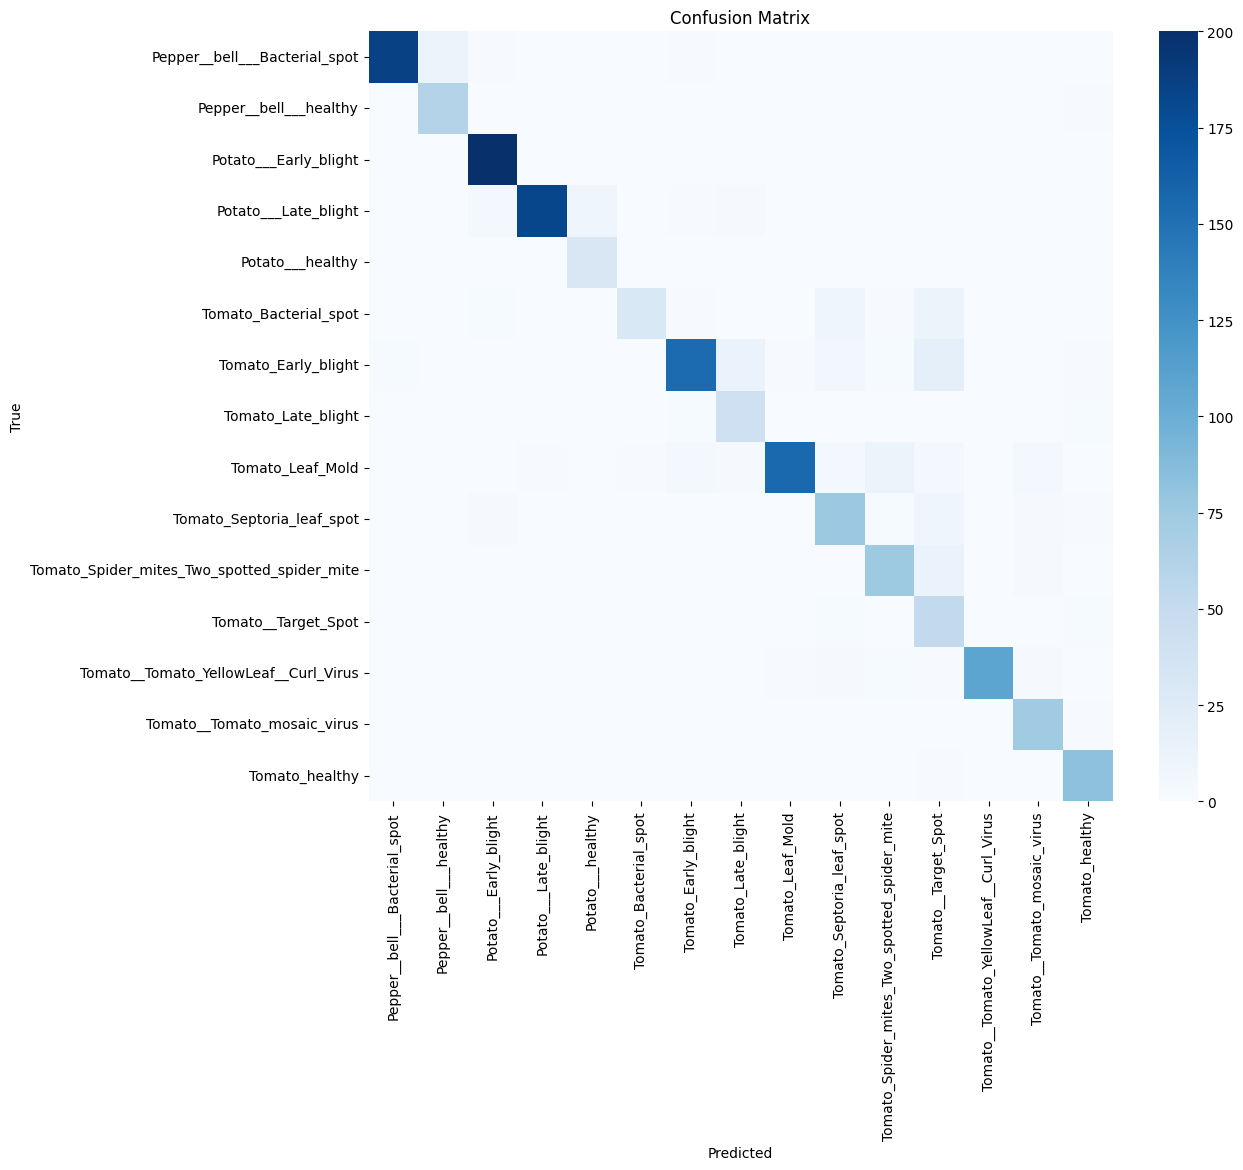

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# -----------------------
# 1. Dataset
# -----------------------
img_size = (224, 224)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# ✅ Get class names BEFORE cache/prefetch
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Cache + prefetch for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# -----------------------
# 2. Data Augmentation
# -----------------------
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomBrightness(factor=0.2),
])

# -----------------------
# 3. Build Model
# -----------------------
base_model = keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=img_size + (3,)
)
base_model.trainable = False  # phase 1: frozen

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# -----------------------
# 4. Compile
# -----------------------
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# 5. Callbacks
# -----------------------
checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"
)
earlystop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

# -----------------------
# 6. Training Phase 1 (frozen base)
# -----------------------
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

# -----------------------
# 7. Fine-tuning Phase 2 (unfreeze last 100 layers)
# -----------------------
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # smaller LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

print("✅ Training complete. Best model saved as best_model.keras")

# -----------------------
# 8. Evaluation
# -----------------------
# Load best model
best_model = keras.models.load_model("best_model.keras")

# Predict on validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from collections import Counter

# -----------------------
# 1. Dataset
# -----------------------
img_size = (224, 224)
batch_size = 32

train_ds_raw = keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Save class names before cache/prefetch
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# -----------------------
# 2. Compute Class Weights
# -----------------------
all_labels = []
for _, label in train_ds_raw.unbatch():
    all_labels.append(label.numpy())   # use append

counts = Counter(all_labels)
total = sum(counts.values())
class_weights = {i: total / (num_classes * count) for i, count in counts.items()}

print("Class Weights:", class_weights)

# -----------------------
# 3. Data Augmentation
# -----------------------
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomBrightness(factor=0.2),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

# -----------------------
# 4. Build Model
# -----------------------
base_model = keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=img_size + (3,)
)
base_model.trainable = False  # phase 1: frozen

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# -----------------------
# 5. Compile
# -----------------------
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# 6. Callbacks
# -----------------------
checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"
)
earlystop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

# -----------------------
# 7. Training Phase 1 (frozen base)
# -----------------------
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint, earlystop]
)

# -----------------------
# 8. Fine-tuning Phase 2 (last 100 layers)
# -----------------------
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, earlystop]
)

# -----------------------
# 9. Fine-tuning Phase 3 (entire model, very low LR)
# -----------------------
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint, earlystop]
)

print("✅ Training complete. Best model saved as best_model.keras")


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Class Weights: {np.int32(2): 1.6709677419354838, np.int32(14): 0.8491803278688524, np.int32(9): 1.295, np.int32(6): 1.295, np.int32(12): 0.8354838709677419, np.int32(3): 0.9773584905660377, np.int32(10): 1.4388888888888889, np.int32(4): 0.428099173553719, np.int32(8): 1.5235294117647058, np.int32(13): 0.7848484848484848, np.int32(7): 1.1772727272727272, np.int32(11): 0.6906666666666667, np.int32(1): 1.036, np.int32(5): 1.85, np.int32(0): 1.4388888888888889}
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from tensorflow import keras

# -----------------------
# Callbacks
# -----------------------
checkpoint_best = keras.callbacks.ModelCheckpoint(
    "model_best.keras", save_best_only=True,
    monitor="val_accuracy", mode="max"
)

checkpoint_latest = keras.callbacks.ModelCheckpoint(
    "model_latest.keras", save_best_only=False
)

earlystop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

# -----------------------
# Training (Phase 1, frozen base)
# -----------------------
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_best, checkpoint_latest, earlystop]
)

# -----------------------
# Training (Phase 2, fine-tune last 100 layers)
# -----------------------
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint_best, checkpoint_latest, earlystop]
)

# -----------------------
# Training (Phase 3, fine-tune all layers with very low LR)
# -----------------------
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_best, checkpoint_latest, earlystop]
)

print("✅ Training complete. Best model -> model_best.keras | Latest model -> model_latest.keras")


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 554ms/step - accuracy: 0.9296 - loss: 0.2779 - val_accuracy: 0.8626 - val_loss: 0.4031
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.9320 - loss: 0.2670 - val_accuracy: 0.8585 - val_loss: 0.4197
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 514ms/step - accuracy: 0.9502 - loss: 0.2138 - val_accuracy: 0.8503 - val_loss: 0.4365
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 573ms/step - accuracy: 0.9630 - loss: 0.1914 - val_accuracy: 0.8479 - val_loss: 0.4536
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - accuracy: 0.9474 - loss: 0.2013 - val_accuracy: 0.8438 - val_loss: 0.4683
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - accuracy: 0.9584 - loss: 0.1961 - val_accuracy: 0.8350 - val_loss: 0.4853
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 534ms/step - accuracy: 0.9852 - loss: 0.0889 - val_accuracy: 0.8573 - val_loss: 0.4313
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.9862 - loss: 0.0769 - val_accur

In [ ]:
# ----------------------------------
# 1. Mount Drive & Paths
# ----------------------------------
from google.colab import drive
drive.mount('/content/drive')

import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

base_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split"
checkpoint_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# ----------------------------------
# 2. Dataset
# ----------------------------------
img_size = (224, 224)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, "train"),
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, "val"),
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("✅ Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ----------------------------------
# 3. Data Augmentation
# ----------------------------------
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomBrightness(factor=0.2),
    keras.layers.RandomTranslation(0.1, 0.1),
])

# ----------------------------------
# 4. Build Model
# ----------------------------------
base_model = keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=img_size + (3,)
)
base_model.trainable = False  # Phase 1 frozen

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# ----------------------------------
# 5. Compile
# ----------------------------------
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ----------------------------------
# 6. Callbacks
# ----------------------------------
checkpoint_best = keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_dir, "model_best.keras"),
    save_best_only=True, monitor="val_accuracy", mode="max"
)
checkpoint_latest = keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_dir, "model_latest.keras"),
    save_best_only=False, save_freq="epoch"
)
earlystop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

# ----------------------------------
# 7. Training Phase 1 (frozen base)
# ----------------------------------
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=10, callbacks=[checkpoint_best, checkpoint_latest, earlystop]
)

# ----------------------------------
# 8. Fine-tuning Phase 2 (last 100 layers)
# ----------------------------------
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=15, callbacks=[checkpoint_best, checkpoint_latest, earlystop]
)

# ----------------------------------
# 9. Fine-tuning Phase 3 (entire model, small LR)
# ----------------------------------
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history3 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=10, callbacks=[checkpoint_best, checkpoint_latest, earlystop]
)

print("✅ Training complete. Best model saved at:", os.path.join(checkpoint_dir, "model_best.keras"))

# ----------------------------------
# 10. Load Best Model & Predict
# ----------------------------------
best_model = keras.models.load_model(os.path.join(checkpoint_dir, "model_best.keras"))

# Test with a single image
def predict_image(img_path):
    img = keras.utils.load_img(img_path, target_size=img_size)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.efficientnet.preprocess_input(img_array)

    preds = best_model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds) * 100

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

# Example usage:
# predict_image("/content/drive/My Drive/PlantDisease_EfficientNetB0/test_sample/tomato_leaf.jpg")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
✅ Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 771ms/step - accuracy: 0.1405 - loss: 2.6142 - val_accuracy: 0.1920 - val_loss: 2.3700
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 284ms/step - accuracy: 0.4093 - loss: 2.0082 - val_accuracy: 0.3752 - val_loss: 1.9545
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.5400 - loss: 1.5894 - val_accuracy: 0.4833 -

In [ ]:
import os
from collections import Counter

dataset_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage"
class_counts = {cls: len(os.listdir(os.path.join(dataset_dir, cls))) for cls in os.listdir(dataset_dir)}
print(class_counts)


{'Pepper__bell___Bacterial_spot': 882, 'Pepper__bell___healthy': 471, 'Potato___Early_blight': 493, 'Potato___Late_blight': 494, 'Potato___healthy': 152, 'Tomato_Bacterial_spot': 485, 'Tomato_Early_blight': 497, 'Tomato_Late_blight': 469, 'Tomato_Leaf_Mold': 489, 'Tomato_Septoria_leaf_spot': 1771, 'Tomato_Spider_mites_Two_spotted_spider_mite': 469, 'Tomato__Target_Spot': 392, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 464, 'Tomato__Tomato_mosaic_virus': 373, 'Tomato_healthy': 488}


In [ ]:
# Save the full model
model.save("/content/drive/My Drive/PlantDisease_EfficientNetB0/model_with_partial_training.keras")


In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/My Drive/PlantDisease_EfficientNetB0/model_with_partial_training.keras")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow import keras

# Load your previously saved model
model = keras.models.load_model("/content/drive/My Drive/PlantDisease_EfficientNetB0/model_with_partial_training.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

img_size = (224, 224)  # change if different during training
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train",
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val",
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [24]:
import os

train_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        print(f"{cls}: {len(os.listdir(cls_path))}")


Pepper__bell___Bacterial_spot: 36
Pepper__bell___healthy: 50
Potato___Early_blight: 31
Potato___Late_blight: 53
Potato___healthy: 121
Tomato_Bacterial_spot: 28
Tomato_Early_blight: 40
Tomato_Late_blight: 44
Tomato_Leaf_Mold: 34
Tomato_Septoria_leaf_spot: 40
Tomato_Spider_mites_Two_spotted_spider_mite: 36
Tomato__Target_Spot: 75
Tomato__Tomato_YellowLeaf__Curl_Virus: 63
Tomato__Tomato_mosaic_virus: 66
Tomato_healthy: 61


In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Match your training class order
classes = [
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy'
]

counts = [36, 50, 31, 53, 121, 28, 40, 44, 34, 40, 36, 75, 63, 66, 61]

labels = []
for idx, count in enumerate(counts):
    labels.extend([idx] * count)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.4407407407407407), 1: np.float64(1.0373333333333334), 2: np.float64(1.6731182795698925), 3: np.float64(0.9786163522012579), 4: np.float64(0.4286501377410468), 5: np.float64(1.8523809523809525), 6: np.float64(1.2966666666666666), 7: np.float64(1.1787878787878787), 8: np.float64(1.5254901960784313), 9: np.float64(1.2966666666666666), 10: np.float64(1.4407407407407407), 11: np.float64(0.6915555555555556), 12: np.float64(0.8232804232804233), 13: np.float64(0.7858585858585858), 14: np.float64(0.8502732240437159)}


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model during training
checkpoint_cb = ModelCheckpoint(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/best_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

# Stop training early if validation accuracy doesn’t improve
earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)


In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 698s 28s/step - accuracy: 0.9681 - loss: 0.1186 - val_accuracy: 0.8790 - val_loss: 0.3644
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.9853 - loss: 0.0877 - val_accuracy: 0.8761 - val_loss: 0.3813
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.9890 - loss: 0.0688 - val_accuracy: 0.8743 - val_loss: 0.3839
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 0.9944 - loss: 0.0710 - val_accuracy: 0.8808 - val_loss: 0.3685
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - accuracy: 0.9933 - loss: 0.0697 - val_accuracy: 0.8767 - val_loss: 0.3905
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - accuracy: 0.9793 - loss: 0.0781 - val_accuracy: 0.8820 - val_loss: 0.3789
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 558ms/step - accuracy: 0.9821 - loss: 0.0672 - val_accuracy: 0.8767 - val_loss: 0.3910
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.9750 - loss: 0.0706 - val_accuracy

In [29]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2)  # if TF version supports
])


In [30]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [33]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

num_classes = 15   # <-- your dataset classes

# Define base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze first for transfer learning

# Add classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=output)


In [34]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir   = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation generator (no augmentation, just rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Build generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 777 images belonging to 15 classes.
Found 1703 images belonging to 15 classes.


In [39]:
print("Classes:", train_generator.class_indices)
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Num classes (from generator):", train_generator.num_classes)


Classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}
Train samples: 777
Validation samples: 1703
Num classes (from generator): 15


In [40]:
from tensorflow.keras import layers, models, applications

# Base model (EfficientNetB0)
base_model = applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # first stage: freeze

# Build classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(train_generator.num_classes, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train stage 1
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

# Fine-tune stage 2 (unfreeze last 40 layers)
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.1256 - loss: 2.7219 - val_accuracy: 0.0182 - val_loss: 2.9120
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 763ms/step - accuracy: 0.1386 - loss: 2.6751 - val_accuracy: 0.0182 - val_loss: 2.9020
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 788ms/step - accuracy: 0.1664 - loss: 2.6444 - val_accuracy: 0.0182 - val_loss: 2.8245
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 926ms/step - accuracy: 0.1192 - loss: 2.6692 - val_accuracy: 0.0182 - val_loss: 2.9423
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 761ms/step - accuracy: 0.1560 - loss: 2.6708 - val_accuracy: 0.0182 - val_loss: 2.8961
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.1497 - loss: 2.7547 - val_accuracy: 0.0693 - val_loss: 2.8431
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 782ms/step - accuracy: 0.1149 - loss: 2.7085 - val_accuracy: 0.0182 - val_loss: 2.8696
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 782ms/step - accuracy: 0.1206 - loss: 2.7501 - val_accuracy: 0.069

In [41]:
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Classes:", train_generator.class_indices)


Train samples: 777
Validation samples: 1703
Classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Class weights: {0: np.float64(1.4388888888888889), 1: np.float64(1.036), 2: np.float64(1.6709677419354838), 3: np.float64(0.9773584905660377), 4: np.float64(0.428099173553719), 5: np.float64(1.85), 6: np.float64(1.295), 7: np.float64(1.1772727272727272), 8: np.float64(1.5235294117647058), 9: np.float64(1.295), 10: np.float64(1.4388888888888889), 11: np.float64(0.6906666666666667), 12: np.float64(0.8354838709677419), 13: np.float64(0.7848484848484848), 14: np.float64(0.8491803278688524)}
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.0861 - loss: 2.8174 - val_accuracy: 0.3488 - val_loss: 2.2364 - learning_rate: 0.0010
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.3994 - loss: 2.0858 - val_accuracy: 0.4768 - val_loss: 1.8735 - learning_rate: 0.0010
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - accuracy: 0.5473 - loss: 1.7015 - val_accuracy: 0.5273 - val_loss: 1.6515 - learning_rate: 0.0010
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step

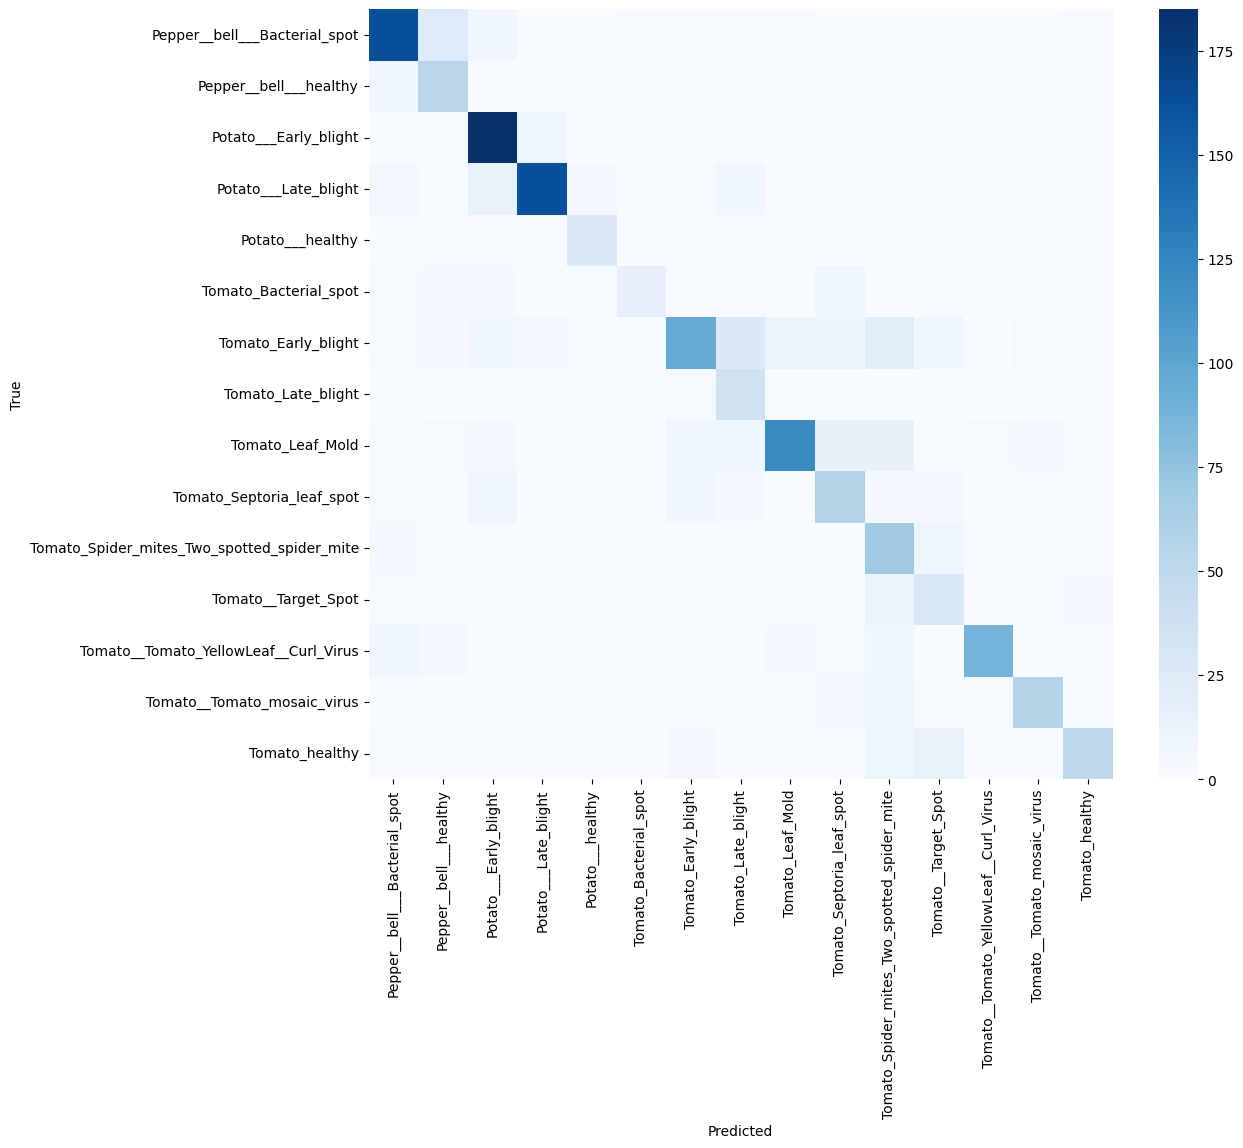

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
('Tomato_Late_blight', np.float32(0.16738307))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
('Tomato_Late_blight', np.float32(0.16542749))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
('Tomato_Late_blight', np.float32(0.16352177))


In [42]:
# ---------------------------
# 1. Setup
# ---------------------------
import os, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS_HEAD = 10
EPOCHS_FINE = 30

# ---------------------------
# 2. Load dataset
# (Assumes PlantVillage is organized as train/ and val/ with class folders)
# ---------------------------
train_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir   = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

train_gen = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_gen = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_gen.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ---------------------------
# 3. Data augmentation
# ---------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2),
])

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_gen = train_gen.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(AUTOTUNE)
val_gen = val_gen.prefetch(AUTOTUNE)

# ---------------------------
# 4. Build EfficientNetB0
# ---------------------------
base_model = keras.applications.EfficientNetB0(
    include_top=False, input_shape=IMG_SIZE + (3,), weights="imagenet"
)
base_model.trainable = False  # Phase 1: freeze

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

# ---------------------------
# 5. Compute class weights (handle imbalance)
# ---------------------------
all_labels = []
for _, y in train_gen.unbatch():
    all_labels.append(int(y.numpy()))
all_labels = np.array(all_labels)
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(all_labels), y=all_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# ---------------------------
# 6. Phase 1 Training (frozen base)
# ---------------------------
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    class_weight=class_weights,
    callbacks=callbacks
)

# ---------------------------
# 7. Phase 2 Training (fine-tune last 50 layers)
# ---------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # smaller LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    class_weight=class_weights,
    callbacks=callbacks
)

# ---------------------------
# 8. Evaluation
# ---------------------------
# Reload best weights
model = keras.models.load_model("best_model.keras")

val_labels = np.concatenate([y.numpy() for _, y in val_gen])
val_preds = model.predict(val_gen)
val_pred_classes = np.argmax(val_preds, axis=1)

print(classification_report(val_labels, val_pred_classes, target_names=class_names))

cm = confusion_matrix(val_labels, val_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------------------------
# 9. Prediction helper
# ---------------------------
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(path):
    img = load_img(path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)
    preds = model.predict(img_array)
    top = np.argmax(preds)
    return class_names[top], preds[0][top]

# Example usage:
# print(predict_image("/content/PlantVillage/test/tomato.jpg"))
print(predict_image("/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf1.jpg"))
print(predict_image("/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf2.jpg"))
print(predict_image("/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf3.jpg"))

In [46]:
model.save("best_model.keras")


In [48]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("best_model.keras", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpoditsi1j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_2782')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  139271793497040: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139271793497808: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139271796287696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139271796287504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139271796288080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139271796289040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139271796289616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139271796288464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139271796288272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139271796289424: TensorSpec(shape=(), dtype=tf.resource, nam

In [54]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load saved model
model = tf.keras.models.load_model("/content/drive/MyDrive/PlantDisease_EfficientNetB0/best_model.keras")

# Class indices (same order as training generator)
class_indices = {
    'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1,
    'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4,
    'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7,
    'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9,
    'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
    'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
    'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14
}
inv_class_indices = {v: k for k, v in class_indices.items()}

def predict_leaf(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # resize to 224x224
    img_array = image.img_to_array(img) / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dim

    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    confidence = np.max(preds[0]) * 100

    print(f"Prediction: {inv_class_indices[predicted_class]} ({confidence:.2f}%)")

# Example
# predict_leaf("/content/drive/MyDrive/PlantDisease_EfficientNetB0/test/leaf1.jpg")
# predict_leaf("/content/drive/MyDrive/PlantDisease_EfficientNetB0/test/leaf2.jpg")
predict_leaf("/content/drive/MyDrive/PlantDisease_EfficientNetB0/test/leaf3.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Tomato_Late_blight (36.54%)


In [55]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Folder where test images are stored
test_folder = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/test"

def batch_predict(folder):
    img_paths = [os.path.join(folder, fname) for fname in os.listdir(folder)]
    imgs = []

    for path in img_paths:
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        imgs.append(img_array)

    imgs = np.array(imgs)  # shape: (N, 224, 224, 3)
    preds = model.predict(imgs)

    for i, path in enumerate(img_paths):
        predicted_class = np.argmax(preds[i])
        confidence = np.max(preds[i]) * 100
        print(f"{os.path.basename(path)} → {inv_class_indices[predicted_class]} ({confidence:.2f}%)")

# Run batch prediction
batch_predict(test_folder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
leaf2.jpg → Tomato_Late_blight (34.72%)
leaf3.jpg → Tomato_Late_blight (36.54%)
leaf1.jpg → Tomato_Late_blight (36.56%)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/PlantDisease_EfficientNetB0/best_model.keras")

print("✅ Model loaded successfully")


✅ Model loaded successfully


In [7]:
# Manual class index mapping
class_indices = {
    'Pepper__bell___Bacterial_spot': 0,
    'Pepper__bell___healthy': 1,
    'Potato___Early_blight': 2,
    'Potato___Late_blight': 3,
    'Potato___healthy': 4,
    'Tomato_Bacterial_spot': 5,
    'Tomato_Early_blight': 6,
    'Tomato_Late_blight': 7,
    'Tomato_Leaf_Mold': 8,
    'Tomato_Septoria_leaf_spot': 9,
    'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
    'Tomato__Target_Spot': 11,
    'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
    'Tomato__Tomato_mosaic_virus': 13,
    'Tomato_healthy': 14
}

# Inverse mapping {index: class_name}
inv_class_indices = {v: k for k, v in class_indices.items()}


In [8]:
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
confidence = np.max(preds[0]) * 100
class_name = inv_class_indices[predicted_class]
print(f"Prediction: {class_name} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Prediction: Tomato_Late_blight (36.54%)


In [10]:
!ls "/content/drive/MyDrive/"


'Colab Notebooks'	       plant_disease_prediction.ipynb   wbs.drawio.png
 PlantDisease_EfficientNetB0   wbs.drawio


In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/PlantDisease_EfficientNetB0/best_model.keras")

# Class mapping
class_indices = {
    'Pepper__bell___Bacterial_spot': 0,
    'Pepper__bell___healthy': 1,
    'Potato___Early_blight': 2,
    'Potato___Late_blight': 3,
    'Potato___healthy': 4,
    'Tomato_Bacterial_spot': 5,
    'Tomato_Early_blight': 6,
    'Tomato_Late_blight': 7,
    'Tomato_Leaf_Mold': 8,
    'Tomato_Septoria_leaf_spot': 9,
    'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
    'Tomato__Target_Spot': 11,
    'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
    'Tomato__Tomato_mosaic_virus': 13,
    'Tomato_healthy': 14
}
inv_class_indices = {v: k for k, v in class_indices.items()}


In [13]:
def predict_leaf(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    confidence = np.max(preds[0]) * 100
    class_name = inv_class_indices[predicted_class]

    return class_name, confidence


In [20]:
# Single image
class_name, confidence = predict_leaf("/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf1.jpg")
print(f"Prediction: {class_name} ({confidence:.2f}%)")

# Multiple images in a folder
folder_path = "/content/drive/My Drive/PlantDisease_EfficientNetB0/test"
for fname in os.listdir(folder_path):
    if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
        class_name, confidence = predict_leaf(os.path.join(folder_path, fname))
        print(f"{fname} → {class_name} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Prediction: Tomato_Late_blight (36.56%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
leaf3.jpg → Tomato_Late_blight (36.54%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
leaf1.jpg → Tomato_Late_blight (36.56%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
leaf2.jpg → Tomato_Late_blight (34.72%)


In [6]:
# Get mapping {class_name: index}
class_indices = train_generator.class_indices

# Inverse mapping {index: class_name}
inv_class_indices = {v: k for k, v in class_indices.items()}


NameError: name 'train_generator' is not defined

In [5]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

test_folder = "/content/drive/MyDrive/PlantDisease_EfficientNetB0/test"
results = []

for fname in os.listdir(test_folder):
    img_path = os.path.join(test_folder, fname)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    confidence = np.max(preds[0]) * 100
    class_name = inv_class_indices[predicted_class]

    results.append([fname, class_name, confidence])

# Save results to CSV
df = pd.DataFrame(results, columns=["Filename", "Predicted Class", "Confidence (%)"])
df.to_csv("predictions.csv", index=False)

print("✅ Predictions saved to predictions.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


NameError: name 'inv_class_indices' is not defined

In [38]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True
)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,  # balances the classes
    callbacks=[checkpoint_cb, earlystop_cb]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0736 - loss: 2.7041

25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.0733 - loss: 2.7060 - val_accuracy: 0.1174 - val_loss: 2.6991
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 777ms/step - accuracy: 0.0469 - loss: 2.7113 - val_accuracy: 0.1174 - val_loss: 2.6986
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 743ms/step - accuracy: 0.0725 - loss: 2.7526 - val_accuracy: 0.1174 - val_loss: 2.7057
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 913ms/step - accuracy: 0.0709 - loss: 2.7124 - val_accuracy: 0.0452 - val_loss: 2.7134
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 770ms/step - accuracy: 0.0661 - loss: 2.6580 - val_accuracy: 0.0440 - val_loss: 2.7093
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 805ms/step - accuracy: 0.0712 - loss: 2.7148 - val_accuracy: 0.0364 - val_loss: 2.7090
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 886ms/step - accuracy: 0.0490 - loss: 2.6914 - val_accuracy: 0.0558 - val_loss: 2.7128


In [4]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_size = (224, 224)

def predict_image_with_threshold(img_path, threshold=0.5):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index]

    if confidence < threshold:
        return "Uncertain (maybe Healthy)", confidence * 100
    else:
        return class_names[predicted_index], confidence * 100


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
def debug_prediction(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]
    print(f"\nPredictions for {img_path}:")
    for i, prob in enumerate(predictions):
        print(f"{class_names[i]}: {prob*100:.2f}%")

# Run it on your test images
debug_prediction("/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf1.jpg")
debug_prediction("/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf2.jpg")
debug_prediction("/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf3.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Predictions for /content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf1.jpg:
Pepper__bell___Bacterial_spot: 4.14%
Pepper__bell___healthy: 3.94%
Potato___Early_blight: 10.06%
Potato___Late_blight: 3.69%
Potato___healthy: 2.96%
Tomato_Bacterial_spot: 5.15%
Tomato_Early_blight: 3.33%
Tomato_Late_blight: 30.79%
Tomato_Leaf_Mold: 3.97%
Tomato_Septoria_leaf_spot: 6.84%
Tomato_Spider_mites_Two_spotted_spider_mite: 3.23%
Tomato__Target_Spot: 2.86%
Tomato__Tomato_YellowLeaf__Curl_Virus: 4.23%
Tomato__Tomato_mosaic_virus: 5.31%
Tomato_healthy: 9.49%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Predictions for /content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf2.jpg:
Pepper__bell___Bacterial_spot: 4.25%
Pepper__bell___healthy: 4.03%
Potato___Early_blight: 10.17%
Potato___Late_blight: 3.80%
Potato___healthy: 3.04%
Tomato_Bacterial_spot: 5.20%
Tomato_Early_blight: 3.43%
Tomato_Late_blight: 29.58%
Tomato_Leaf_Mold: 4.02%
Tomato_Septoria_leaf_spot: 7.

In [11]:
def predict_image_adaptive(img_path, disease_threshold=0.3, healthy_threshold=0.5):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index]
    predicted_class = class_names[predicted_index]

    if "healthy" in predicted_class:
        if confidence < healthy_threshold:
            return "Uncertain (maybe Healthy)", confidence * 100
    else:
        if confidence < disease_threshold:
            return "Uncertain (maybe Healthy)", confidence * 100

    return predicted_class, confidence * 100


In [16]:
for test_img in [
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf1.jpg",
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf2.jpg",
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf3.jpg"
]:
    label, conf = predict_image_adaptive(test_img)
    print(f"{test_img}: {label} ({conf:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf1.jpg: Tomato_Late_blight (31.15% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf2.jpg: Tomato_Late_blight (30.84% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf3.jpg: Tomato_Late_blight (30.89% confidence)


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load best model
model = tf.keras.models.load_model("/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_best.keras")

# Your class names
class_names = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
               'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
               'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
               'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
               'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
               'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',
               'Tomato_healthy']

# Function to make prediction
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    return class_names[predicted_class], confidence

# Example usage
img_path = "/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf1.jpg"
predicted_class, confidence = predict_image(img_path)
print(f"Prediction for leaf1: {predicted_class} ({confidence:.2f}% confidence)")


# Example usage
img_path = "/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf2.jpg"
predicted_class, confidence = predict_image(img_path)
print(f"Prediction for leaf2: {predicted_class} ({confidence:.2f}% confidence)")


# Example usage
img_path = "/content/drive/My Drive/PlantDisease_EfficientNetB0/test/leaf3.jpg"
predicted_class, confidence = predict_image(img_path)
print(f"Prediction for leaf3: {predicted_class} ({confidence:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction for leaf1: Tomato_Late_blight (30.79% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for leaf2: Tomato_Late_blight (29.58% confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for leaf3: Tomato_Late_blight (30.67% confidence)


In [ ]:
# ============================
# 1. Setup
# ============================
import tensorflow as tf
import os

# Paths to dataset
train_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir   = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

# Build datasets without prefetch first
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

# Get number of classes before prefetch
num_classes = len(train_ds_raw.class_names)
print("Classes:", train_ds_raw.class_names)

# Now add prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds   = val_ds_raw.prefetch(AUTOTUNE)

val_dir   =  "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

img_size = (224, 224)
batch_size = 32

# ============================
# Load dataset
# ============================
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)
# Normalize (0–1 scaling)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds_raw.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)

# Detect classes
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ============================
# 2. Build Model
# ============================
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze backbone

# Custom classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ============================
# 3. Checkpointing
# ============================
checkpoint_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_latest.keras"),
    save_freq="epoch",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

# ============================
# 4. Training Phase 1 (head only)
# ============================
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# ============================
# 5. Training Phase 2 (fine-tuning)
# ============================
base_model.trainable = True
for layer in base_model.layers[:-20]:  # keep all but last 20 frozen
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# ============================
# 6. Evaluation
# ============================
loss, acc = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {acc:.2f}, Loss: {loss:.2f}")

# ============================
# 7. Quick Prediction Test
# ============================
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_classes = preds.argmax(axis=1)
    true_classes = labels.numpy().argmax(axis=1)
    print("Predicted:", pred_classes)
    print("True:     ", true_classes)
    break


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1387 - loss: 2.6655

KeyboardInterrupt: 

In [ ]:
train_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir   = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
).prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
).prefetch(tf.data.AUTOTUNE)

# now you can detect classes
num_classes = len(train_ds.class_names)
print("Classes:", train_ds.class_names)


Found 777 files belonging to 15 classes.
Found 1703 files belonging to 15 classes.


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation="relu")(x)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'num_classes' is not defined

In [ ]:
# 1. Unfreeze top EfficientNet layers
base_model.trainable = True
for layer in base_model.layers[:-20]:  # freeze all but last 20 layers
    layer.trainable = False

# 2. Compile again with very low LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 3. Train further
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # you can increase if needed
    callbacks=[checkpoint_cb, earlystop_cb]
)


NameError: name 'base_model' is not defined

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(image, label):
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess)
val_ds   = val_ds.map(preprocess)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,   # adjust as needed
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4893 - loss: 1.6295
Epoch 1: saving model to /content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_epoch_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 327s 14s/step - accuracy: 0.4896 - loss: 1.6297 - val_accuracy: 0.6013 - val_loss: 1.3841
Epoch 2/20
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5250 - loss: 1.4938
Epoch 2: saving model to /content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_epoch_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.5264 - loss: 1.4926 - val_accuracy: 0.6160 - val_loss: 1.3416
Epoch 3/20
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5662 - loss: 1.4093
Epoch 3: saving model to /content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_epoch_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.5690 - loss: 1.4079 - val_accuracy: 0.6301 - val_loss: 1.3143
Epoch 4/20
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 

Step 4: Prepare dataset (prefetch, cache, shuffle)

This helps speed up training and avoids bottlenecks:

In [ ]:
# Take only 2000 samples from training and 500 from validation
train_subset = train_ds.take(2000 // 32)   # 2000 images / batch size
val_subset   = val_ds.take(500 // 32)


In [ ]:
history = model.fit(
    train_subset,
    validation_data=val_subset,
    epochs=2,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2640 - loss: 2.3915

62/62 ━━━━━━━━━━━━━━━━━━━━ 430s 7s/step - accuracy: 0.2662 - loss: 2.3862 - val_accuracy: 0.6333 - val_loss: 1.4766
Epoch 2/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6326 - loss: 1.3881

62/62 ━━━━━━━━━━━━━━━━━━━━ 48s 788ms/step - accuracy: 0.6331 - loss: 1.3866 - val_accuracy: 0.6979 - val_loss: 1.0944


In [ ]:
import os

train_path = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_path = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

print("Train folders:", os.listdir(train_path)[:5])  # show first 5 classes
print("Val folders:", os.listdir(val_path)[:5])

# Count total images
train_count = sum([len(files) for r, d, files in os.walk(train_path)])
val_count = sum([len(files) for r, d, files in os.walk(val_path)])
print(f"Train images: {train_count}, Val images: {val_count}")


Train folders: []
Val folders: []
Train images: 0, Val images: 0


In [ ]:
import os

base_path = "/content/drive/My Drive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage"
print("Contents of base path:", os.listdir(base_path))


Contents of base path: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
import splitfolders

input_folder = "/content/drive/My Drive/PlantDisease_EfficientNetB0/dataset/plantvillage/PlantVillage"

splitfolders.ratio(
    input_folder,
    output="/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split",
    seed=1337,
    ratio=(0.8, 0.2)  # 80% train, 20% val
)


Copying files: 20639 files [11:06, 30.99 files/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameters
img_size = (224, 224)
batch_size = 16

train_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train"
val_dir = "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val"

# Datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model: EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze for test run

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(15, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Callbacks: Save after each epoch
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

# Train 1 epoch
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[checkpoint_cb]
)


Found 16504 files belonging to 15 classes.
Found 4134 files belonging to 15 classes.
 384/1032 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - accuracy: 0.5703 - loss: 1.5304

In [ ]:
import os

ckpt_path = "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints"
print(os.listdir(ckpt_path))


['model.h5']


In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)


In [ ]:
model.save("/content/drive/My Drive/PlantDisease_EfficientNetB0/checkpoints/model_temp_save.keras")


NameError: name 'model' is not defined

In [ ]:
# Step 1: Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

# Step 2: Dataset (resize smaller)
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/val",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Step 3: Prefetching for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 4: Build model (Transfer Learning)
num_classes = len(train_ds.class_names)

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False  # freeze backbone first

inputs = keras.Input(shape=(img_size[0], img_size[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Step 5: Callbacks (save best model only)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Step 6: Warmup Training (train only final layer)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Step 7: Fine-tuning (unfreeze last 20 layers of EfficientNet)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Found 0 files belonging to 0 classes.


ValueError: No images found in directory /content/drive/My Drive/PlantDisease_EfficientNetB0/PlantVillage_split/train. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [ ]:
# Step 1: Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
import tensorflow as tf


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Step 5: Data augmentation (avoid overfitting)

Since plant images are similar, augmentation is important:

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [1]:
st.write("Model Input Shape:", model.input_shape)


NameError: name 'st' is not defined